In [1]:
import os, sys
sys.path.append(os.getcwd())

import time

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision.utils import make_grid
import torchvision

import scipy.misc
from scipy.misc import imsave
from IPython.display import display, clear_output
from pyro.distributions.relaxed_straight_through import RelaxedBernoulliStraightThrough
from torch.distributions.bernoulli import Bernoulli
from torch.utils.data import RandomSampler, BatchSampler

In [2]:
torch.manual_seed(1)
use_cuda = torch.cuda.is_available()
if use_cuda:
    gpu = 0

In [3]:
DIM = 64 # Model dimensionality
BATCH_SIZE = 50 # Batch size
CRITIC_ITERS = 8 # For WGAN and WGAN-GP, number of critic iters per gen iter
LAMBDA = 10 # Gradient penalty lambda hyperparameter
OUTPUT_DIM = 784 # Number of pixels in MNIST (28*28)
DOWNLOAD_MNIST = False
EPOCHS = 10
DISC_GEN_TRAIN_RATIO = 5 # How many times the discriminator should be trained for one generator train
FEATURE_LENGTH = 256 # How many binary values the encoded stage has
LOAD_MODEL = False

In [4]:
train_data = datasets.MNIST(
    root='./datasets/mnist/',
    transform=torchvision.transforms.ToTensor(),
    download=DOWNLOAD_MNIST,
    train=True,
)
test_data = datasets.MNIST(
    root='./datasets/mnist/',
    transform=torchvision.transforms.ToTensor(),
    download=False,
    train=False,
)

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
trainloader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
trainloader2 = torch.utils.data.DataLoader(dataset=train_data, batch_size=100, shuffle=True)
testloader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE)

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.Tanh(),
        )


        preprocess = nn.Sequential(
            nn.Linear(256, 4*4*4*DIM),
            nn.ReLU(True),
        )
        block1 = nn.Sequential(
            nn.ConvTranspose2d(4*DIM, 2*DIM, 5),
            nn.ReLU(True),
        )
        block2 = nn.Sequential(
            nn.ConvTranspose2d(2*DIM, DIM, 5),
            nn.ReLU(True),
        )
        deconv_out = nn.ConvTranspose2d(DIM, 1, 8, stride=2)

        self.block1 = block1
        self.block2 = block2
        self.deconv_out = deconv_out
        self.preprocess = preprocess
        self.sigmoid = nn.Sigmoid()


    def forward(self, image_batch):
        
        encoded = self.encoder(image_batch)
        bernoulli_encoded = RelaxedBernoulliStraightThrough(0.01, logits=encoded).rsample()
        
        output = self.preprocess(bernoulli_encoded)
        output = output.view(-1, 4*DIM, 4, 4)
        #print output.size()
        output = self.block1(output)
        #print output.size()
        output = output[:, :, :7, :7]
        #print output.size()
        output = self.block2(output)
        #print output.size()
        output = self.deconv_out(output)
        output = self.sigmoid(output)
        #print output.size()
        return output.view(-1, OUTPUT_DIM)

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        main = nn.Sequential(
            nn.Conv2d(1, DIM, 5, stride=2, padding=2),
            # nn.Linear(OUTPUT_DIM, 4*4*4*DIM),
            nn.ReLU(True),
            nn.Conv2d(DIM, 2*DIM, 5, stride=2, padding=2),
            # nn.Linear(4*4*4*DIM, 4*4*4*DIM),
            nn.ReLU(True),
            nn.Conv2d(2*DIM, 4*DIM, 5, stride=2, padding=2),
            # nn.Linear(4*4*4*DIM, 4*4*4*DIM),
            nn.ReLU(True),
            # nn.Linear(4*4*4*DIM, 4*4*4*DIM),
            # nn.LeakyReLU(True),
            # nn.Linear(4*4*4*DIM, 4*4*4*DIM),
            # nn.LeakyReLU(True),
        )
        self.main = main
        self.output = nn.Linear(4*4*4*DIM, 1)

    def forward(self, input):
        input = input.view(-1, 1, 28, 28)
        out = self.main(input)
        out = out.view(-1, 4*4*4*DIM)
        out = self.output(out)
        return out.view(-1)


In [8]:
def calc_gradient_penalty(netD, real_data, fake_data):
    #print real_data.size()
    alpha = torch.rand(BATCH_SIZE, 1)
    alpha = alpha.expand(real_data.size())
    alpha = alpha.cuda(gpu) if use_cuda else alpha

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)

    if use_cuda:
        interpolates = interpolates.cuda(gpu)
    interpolates = autograd.Variable(interpolates, requires_grad=True)

    disc_interpolates = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).cuda(gpu) if use_cuda else torch.ones(
                                  disc_interpolates.size()),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty


In [9]:
netG = Generator()
netD = Discriminator()

if use_cuda:
    netD = netD.cuda(gpu)
    netG = netG.cuda(gpu)

optimizerD = optim.Adam(netD.parameters(), lr=1e-4, betas=(0.5, 0.9))
optimizerG = optim.Adam(netG.parameters(), lr=1e-4, betas=(0.5, 0.9))


In [10]:
if LOAD_MODEL:
    
    checkpoint = torch.load('./models/models.pt')
    netG.load_state_dict(checkpoint['netG_state_dict'])
    netD.load_state_dict(checkpoint['netD_state_dict'])
    optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])
    optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])
    loaded_epoch = checkpoint['epoch']

    netG.eval()
    netD.eval()

In [11]:
def myplot(x,y, name):
    plt.clf()
    plt.plot(x, y, 'ro')
    plt.xlabel('iteration')
    plt.ylabel(name)
    plt.savefig('images/'+name+'.png')

In [12]:
def generate_data(batch_size, feature_length):
    p = torch.empty(batch_size, feature_length).uniform_(0, 1)
    better_encoded = RelaxedBernoulliStraightThrough(0.01, logits=p).rsample()
    return better_encoded #v.type(torch.IntTensor).type(torch.FloatTensor)

In [ ]:
diterats = []
giterats = []
wdistarr = []
dcostarr = []
gcostarr = []
trainloader_length = int(len(trainloader))

if not LOAD_MODEL:
    loaded_epoch = 0
    
for epoch in range(loaded_epoch, EPOCHS):
    for i, (x,y) in enumerate(trainloader):

        x = x.view(-1, 28*28)
        if use_cuda:
            x = x.cuda(gpu)
            
#         if i%(DISC_GEN_TRAIN_RATIO+1) != DISC_GEN_TRAIN_RATIO:
        for iter_d in range(CRITIC_ITERS):

            ############################
            # (1) Update D network
            ###########################

            netD.zero_grad()

            # train with real
            D_real = netD(x).mean()
            # print D_real

            # train with fake

            fake = netG(x).detach()
            D_fake = netD(fake).mean()


            # train with gradient penalty
            gradient_penalty = calc_gradient_penalty(netD, x, fake)

            D_cost = D_fake - D_real + gradient_penalty

            D_cost.backward()

            Wasserstein_D = D_real - D_fake
            optimizerD.step()

        diterats += [i+(epoch*trainloader_length)]
        dcostarr += [D_cost.cpu().detach().numpy()]
        wdistarr += [Wasserstein_D]

        myplot(diterats, dcostarr, "dcost")
        myplot(diterats, wdistarr, "wdist")


        ############################
        # (2) Update G network
        ###########################

        netG.zero_grad()

        fake = netG(x)
        G = netD(fake).mean()

        G_cost = -G
        G_cost.backward()

        optimizerG.step()

        # Write logs and save samples
        giterats += [i+(epoch*trainloader_length)]
        gcostarr += [G_cost.cpu().detach().numpy()]
        myplot(giterats, gcostarr, "gcost")

        if i % 50 == 49:
            x, _ = next(iter(trainloader2))
            x = x.view(-1, 28*28)
            if use_cuda:
                x = x.cuda(gpu)
            fake = netG(x).unsqueeze(1).view(100,1,28,28)
            if use_cuda:
                fake = fake.cpu()
                D_cost = D_cost.cpu()
            save_image(fake, "images/%d.png" % (i+epoch*trainloader_length), nrow=10, normalize=False)
            save_image(x.view(100,1,28,28), "images/%d_original.png" % (i+epoch*trainloader_length), nrow=10, normalize=False)
        
        
        
        
        
        clear_output(wait=True)
        display('Iteration '+str(i)+' , epoch '+str(epoch)+' , total iteration '+str(i+(epoch*int((60000/BATCH_SIZE)))))
        
    torch.save({
        'netG_state_dict': netG.state_dict(),
        'netD_state_dict': netD.state_dict(),
        'optimizerG_state_dict': optimizerG.state_dict(),
        'optimizerD_state_dict': optimizerD.state_dict(),
        'epoch': epoch,
        }, './models/models3.pt')

'Iteration 124 , epoch 3 , total iteration 3724'

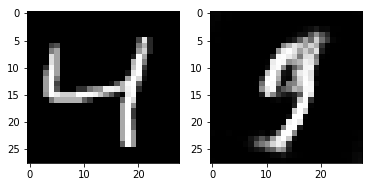

In [51]:
%matplotlib inline
checkpoint = torch.load('./models/models2.pt')
netG.load_state_dict(checkpoint['netG_state_dict'])
netD.load_state_dict(checkpoint['netD_state_dict'])

netG.eval()
netD.eval()

original_pic = train_data.data[2]
formatted_original = original_pic.view(-1, 28*28).type(torch.FloatTensor).cuda(gpu)/255
generated_pic = netG(formatted_original)


f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(original_pic.numpy(), cmap='gray')
f.add_subplot(1,2, 2)
plt.imshow(generated_pic.cpu().view(28,28).detach().numpy(), cmap='gray')
plt.show(block=True)

In [ ]:
def save_encoded_file(encoded_array):
    encoded_array = encoded_array[0].cpu().detach().numpy()
    encoded_string = "".join(encoded_array.astype('int16').astype('str'))
    data = [int(encoded_string[i:i+8], 2) for i in range(0,len(encoded_array),8)]
    bytefile = bytes(data)
    with open("myfile.bin","wb") as f:
        f.write(bytefile)
